In [1]:
## VERSION AVEC MATRICE CONFUSION, TEST SET différent VALIDATION SET, DYNAMIC LR (patience system) ##
# Attention, paramètres du modèles ont été changé, les neurones sont a ajuster en fonction de taille images
# il n'y a plus les courbes loss aussi, mais vous pouvez les rajouter simplement


import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 64
#image_size = (32, 32, 3)

train_set = ImageFolder('/home/selen/Documents/BioInfo_Master/stage BIosciences/TrainingSet', transform=transform)
test_set = ImageFolder('/home/selen/Documents/BioInfo_Master/stage BIosciences/TestSet', transform=transform)

train_size = int(0.8 * len(train_set))
valid_size = len(train_set) - train_size
train_set, valid_set = random_split(train_set, [train_size, valid_size])

train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

valid_loader = T.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [27]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3),
           
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(10245, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1000, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0],-1)
        x = self.classifier(x)
        return x

In [28]:
#torch.cuda.empty_cache()
net = AlexNet()
net.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): ReLU(i

In [29]:
criterion = nn.CrossEntropyLoss()

# also the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

In [ ]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

for epoch in range(0, 250):
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):

        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)


        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    if epoch % 10 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # VALIDATION LOOP
    with T.no_grad():
        correct = 0
        total = 0
        valid_running_loss = .0
        for data in valid_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        valid_running_loss /= len(valid_loader)
        valid_loss.append(valid_running_loss)
        valid_running_acc = correct / total
        valid_acc.append(valid_running_acc)
        
        if epoch % 10 == 0:
            print('valid Acc.  => {:.3f}%'.format(100 * valid_running_acc), end=' | ')
            print('valid Loss  => {:.5f}'.format(valid_running_loss))

print('Finished Training')

## Visualization

In [33]:
torch.save(net.state_dict(), "/home/selen/Documents/BioInfo_Master/stage BIosciences/Images_exemple/complet/run8bitbetter")
torch.save(net, "/home/selen/Documents/BioInfo_Master/stage BIosciences/Images_exemple/complet/run8bnibett")

In [34]:
#####
# Test loop pour obtenir accuracy pour chaque classe
#####


classes = ('Good','Bad')
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        if device == 'cuda':
            images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy pour la classe: {classname:5s} is {accuracy:.1f} %')

Accuracy pour la classe: Good  is 78.8 %
Accuracy pour la classe: Bad   is 35.3 %


In [35]:
#####
# Test loop pour obtenir accuracy pour chaque classe
#####

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        if device == 'cuda':
            images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy complète sur le test set: {100 * correct // total} %')

Accuracy complète sur le test set: 57 %


<AxesSubplot:>

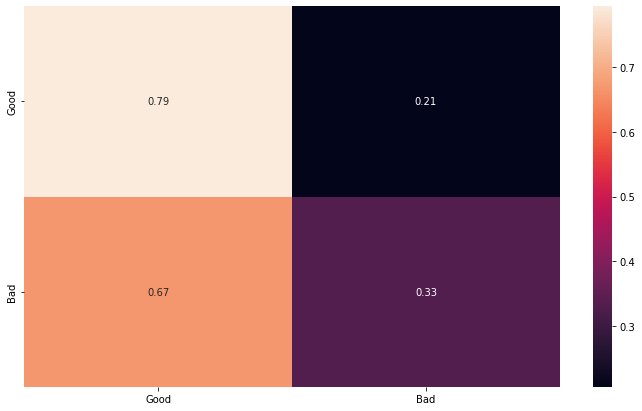

In [36]:
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []

# on parcours test data
for inputs, labels in test_loader:
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)
            
        # envoie dans le modèle
        output = net(inputs)
        
        # on regarde la prédiction
        output = (T.max(T.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        # et on sauvegarde le vrai label
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)
        
classes = ('Good', 'Bad')

cf_matrix = confusion_matrix(y_true, y_pred,normalize='true')
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *2, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
976 Good / 918 Bad dans training set (qui se divise en 80%/20% avec valdiation set)
320 / 278 pour le test set